# 例題：メッセージ数に変化はあるか？
- あるユーザーが毎日受診するメッセージの数という数列が与えられたとする

In [1]:
# install data
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import scipy
from os import makedirs
from urllib.request import urlretrieve


makedirs("../data", exist_ok=True)

urlretrieve("https://git.io/vXTVC", "../data/txtdata.csv")

('../data/txtdata.csv', <http.client.HTTPMessage at 0x111148908>)

(0, 74)

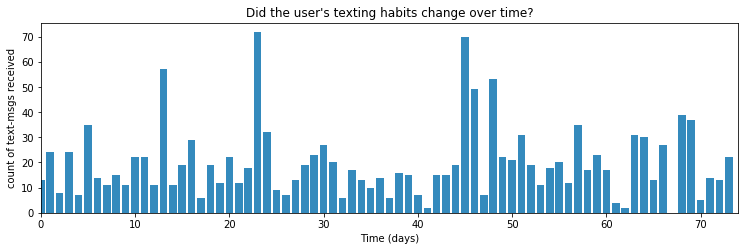

In [2]:
# message
figsize(12.5, 3.5)

count_data = np.loadtxt('../data/txtdata.csv')
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color='#348ABD')

plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data)

- どのようにモデリングすればいいだろう
- i日目のメッセージ数を$C_i$とすると
$$ C_i\sim Poi(\lambda) $$
- ある日($\tau$)において、パラメータ$\lambda$が突然大きくなる→パラメータを二つ持つ

$$ 
\begin{eqnarray}
\lambda = 
\left\{
\begin{array}{l}
\lambda_1 (t<\tau のとき)\\
\lambda_2 (t\geq \tau のとき)
\end{array}
\right.
\end{eqnarray}
$$

- やるべきことは$\lambda$の推定
- それぞれ事前分布を決める必要がある
- 指数分布がちょうどいいが、下記のように$\alpha$のハイパーパラメータを持つ

$$
\lambda_1 \sim Exp(\alpha)\\
\lambda_2 \sim Exp(\alpha)
$$

- ここでは計数データの平均をとって、その逆数とする
- なぜか。指数分布で$\lambda$をモデル化していて、その期待値は下記のようになるから
- ポワソン分布の期待値は$\lambda$

$$ \frac{1}{N} \sum_{i=0}^N C_i \approx E[\lambda | \alpha]=\frac{1}{\alpha}$$

- こうすれば事前分布のパラメータに主観が入ることは避けられるし、ハイパーパラメータの値の影響を最小限に抑えられる
- $\tau$に関しては一様分布を使う
$$ \tau \sim DiscreteUniform(1,70) \Rightarrow P(\tau = k)=\frac{1}{70} $$

# 必殺の一撃:PyMC
- PyMCはベイズ推論のためのpythonライブラリ
- このような種類のプログラミングを確率的プログラミングという
- モデルの構成要素は$(\tau , \lambda_1 , \lambda_2)$を確率変数にしている

In [4]:
import pymc as pm
# 変数count_dataが計数データを保持
alpha = 1.0/count_data.mean()

lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)

tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)
print("Random output:", tau.random(), tau.random(), tau.random())

Random output: 33 5 47


In [6]:
@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_count_data)  # total of data
    out[:tau] = lambda_1  # tauより前のlambdaはlambda_1
    out[tau:] = lambda_2  # tauより前のlambdaはlambda_2
    return out

- @pm.deterministicはデコレータで、関数が決定的(2.1.2)であることをPyMCに伝える

In [7]:
observation = pm.Poisson("obs", lambda_, value=count_data, observed=True)
model = pm.Model([observation, lambda_1, lambda_2, tau])

- ↓MCMCによってサンプリング

In [8]:
# Mysterious code to be explained in Chapter 3.
mcmc = pm.MCMC(model)
mcmc.sample(40000, 10000, 1)

 [-----------------100%-----------------] 40000 of 40000 complete in 5.6 sec

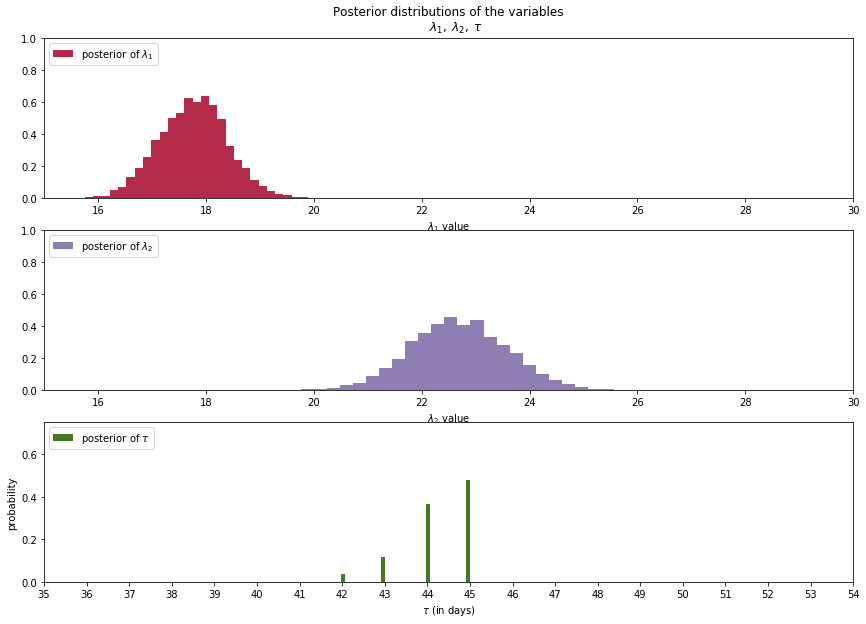

In [9]:
lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
tau_samples = mcmc.trace('tau')[:]

figsize(14.5, 10)
# histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data) - 20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

# 解釈
- 未知数である二つの$\lambda$と$\tau$の分布が得られる
- 分散が高ければその値は不確実
- $\lambda_1$は18、$\lambda_2$は23が妥当であるとわかる
- 二つの$\lambda$の事前分布は指数分布だったのに事後分布は指数分布に見えない→計算したからわかった
- $\tau$をみると45日くらいにユーザーが振る舞いを変えた確率が50%とわかる

# 事後分布からサンプリングすると何が嬉しいの？
- 事後分布からのサンプルを使って、**t日目$(0\leq t \leq 70)$のメッセージ数の期待値を求める**
- t日目の$\lambda$の期待値は何かを求める
- iは事後分布からのサンプルを表すインデックスとする。
- 日数tが与えられた時、もし$t<\tau_i$なら$\lambda_i = \lambda_{1,i}$ そうでないなら$\lambda_i = \lambda_{2,i}$

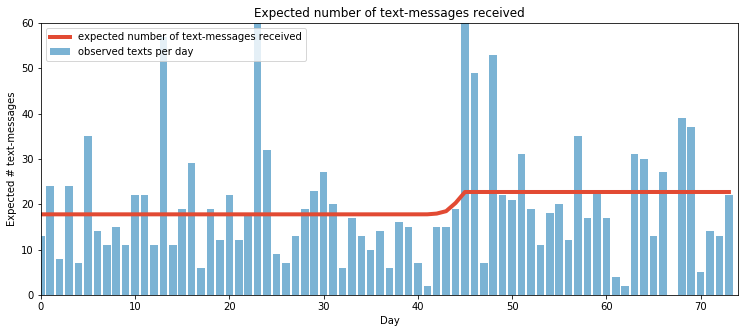

In [12]:
figsize(12.5, 5)

# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)

for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N
    
plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

# 付録
- $\lambda_1と\lambda_2$の事後分布は異なっているが、二つの分布が近かったり重なっていたらどうするの
- 一つは $P(\lambda_1 < \lambda_2|data)$ を計算する  
    
    - 観測データが与えられた時$\lambda_1 < \lambda_2$の確率は？

In [15]:
print(lambda_1_samples < lambda_2_samples)
# どのくらい起こりやすいか
print((lambda_1_samples < lambda_2_samples).sum())
# sample数はいくつ
print(lambda_1_samples.shape[0])
# 確率
print((lambda_1_samples < lambda_2_samples).mean())

[ True  True  True ...  True  True  True]
30000
30000
1.0


In [16]:
# lambdaが1とか2だけ異なっている確率
for d in [1, 2, 5, 10]:
    v = (abs(lambda_1_samples - lambda_2_samples) >= d).mean()
    print("What is the probability the difference is larger than {} {}".format(d, v))

What is the probability the difference is larger than 1 0.9999666666666667
What is the probability the difference is larger than 2 0.9961666666666666
What is the probability the difference is larger than 5 0.4782
What is the probability the difference is larger than 10 0.0
